# Atividade de Redes Convolucionais

## Felipe Gibin

## 1. Introdução

### 1.1 Bibliotecas

In [36]:
#Bibliotecas usadas
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping

## 2. Pré-processamento e Organização dos Dados

### 2.1 Estrutura do Dataset

O dataset segue a seguinte estrutura:

```text
clouds/
├── cloud_train/
│   ├── cirriform clouds/
│   ├── cumulonimbus clouds/
│   ├── stratiform clouds/
│   ├── clear sky/
│   └── ... (outros tipos de nuvem)
└── cloud_test/
    ├── cirriform clouds/
    ├── cumulonimbus clouds/
    ├── stratiform clouds/
    ├── clear sky/
    └── ... (outros tipos de nuvem)
```


### 2.2 Carregar os Dados

In [37]:
drive.mount('/content/drive') # Google drive

#Caminhos para os diretórios de treino e teste
train_dir = '/content/drive/MyDrive/clouds/clouds_train'
test_dir = '/content/drive/MyDrive/clouds/clouds_test'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
#Checa a distribuição dos diretórios de treino e teste
def contar_imagens_por_classe(diretorio_base):
    total = 0
    print(f'\nDiretório: {diretorio_base}')
    for classe in os.listdir(diretorio_base):
        caminho_classe = os.path.join(diretorio_base, classe)
        if os.path.isdir(caminho_classe):
            num_imgs = len([f for f in os.listdir(caminho_classe) if os.path.isfile(os.path.join(caminho_classe, f))])
            total += num_imgs
            print(f'  Classe "{classe}": {num_imgs} imagens')
    print(f'Total de imagens em {diretorio_base}: {total}')
    return total


# Contagem
contar_imagens_por_classe(train_dir)
contar_imagens_por_classe(test_dir)



Diretório: /content/drive/MyDrive/clouds/clouds_train
  Classe "cirriform clouds": 66 imagens
  Classe "stratiform clouds": 49 imagens
  Classe "cumulonimbus clouds": 14 imagens
  Classe "stratocumulus clouds": 61 imagens
  Classe "high cumuliform clouds": 133 imagens
  Classe "clear sky": 60 imagens
  Classe "cumulus clouds": 91 imagens
Total de imagens em /content/drive/MyDrive/clouds/clouds_train: 474

Diretório: /content/drive/MyDrive/clouds/clouds_test
  Classe "cumulus clouds": 120 imagens
  Classe "stratocumulus clouds": 71 imagens
  Classe "high cumuliform clouds": 103 imagens
  Classe "stratiform clouds": 40 imagens
  Classe "clear sky": 64 imagens
  Classe "cirriform clouds": 77 imagens
  Classe "cumulonimbus clouds": 11 imagens
Total de imagens em /content/drive/MyDrive/clouds/clouds_test: 486


486

### 2.3 Dividir os dados

É preciso reorganizar o dataset de forma a aumentar a quantidade de dados em train_data. Uma divisão 50-50% é muito incomum e não faz sentido. Vamos resolver isso de forma a aumentar a proporção de train_data para 80%. Criei uma pasta nova no drive chamada clouds_all. contendo todas as imagens para cada tipo de núvem, de forma que a nova estrutura dos diretórios é:

```text
clouds_all/
├── cirriform clouds/
├── cumulonimbus clouds/
├── stratiform clouds/
├── clear sky/
├── cumulus clouds/
├── high cumuliform clouds/
├── stratocumulus clouds/
```

In [39]:
# Configurações
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
SEED = 123
all_data_dir = '/content/drive/MyDrive/clouds/clouds_all'

# Criar dataset completo
full_ds = image_dataset_from_directory(
    all_data_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=True,
    seed=SEED
)

# Calcular tamanho do dataset
total_images = len(full_ds.file_paths)  # Correto: número total de imagens
train_size = int(0.8 * total_images)
val_size = int(0.1 * total_images)
test_size = total_images - train_size - val_size

print(f"Total de imagens: {total_images}")
print(f"Treino: {train_size} | Validação: {val_size} | Teste: {test_size}")

# Criar datasets divididos
train_ds = full_ds.take(train_size // BATCH_SIZE)
remaining = full_ds.skip(train_size // BATCH_SIZE)
val_ds = remaining.take(val_size // BATCH_SIZE)
test_ds = remaining.skip(val_size // BATCH_SIZE)

Found 960 files belonging to 7 classes.
Total de imagens: 960
Treino: 768 | Validação: 96 | Teste: 96


In [40]:
print(f"Train: {len(train_paths)} imagens")
print(f"Val: {len(val_paths)} imagens")
print(f"Test: {len(test_paths)} imagens")

Train: 768 imagens
Val: 96 imagens
Test: 96 imagens


### 2.3 Visualização de algumas imagens

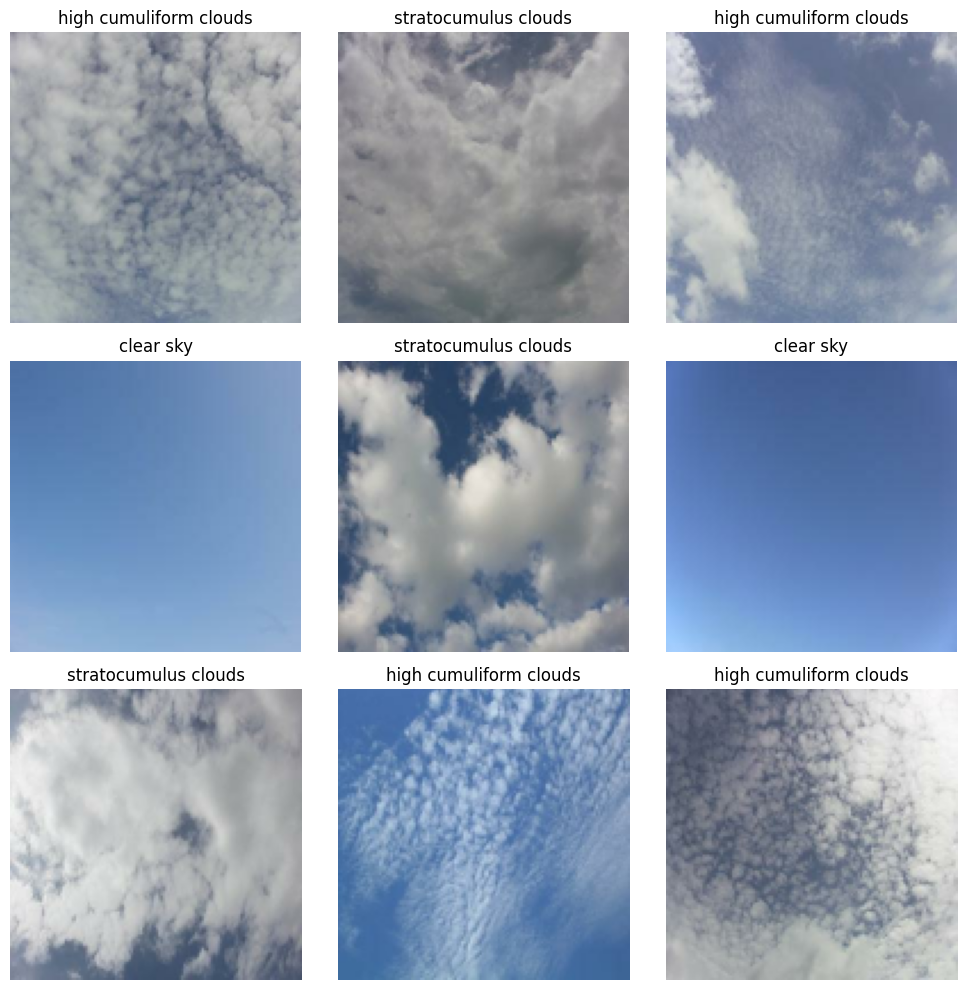

In [41]:
# pega apenas o primeiro batch
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):  # mostrar 9 imagens aleatórias
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy().argmax()])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

## 3. CNN sem data augmentation



### 3.1 Definindo o modelo

In [61]:
model_cnn_no_reg = Sequential([
    layers.Input(shape=(128,128, 3)),
    layers.Rescaling(1./255),  # Normalização

    # Blocos Convolucionais
    layers.Conv2D(32, (3, 3), activation="relu", padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, (3, 3), activation="relu", padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, (3, 3), activation="relu", padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),  # Processa o resultado do flatten
    layers.Dense(7, activation="softmax")  # 7 classes
])

### 3.2 Treinamento

In [62]:
model_cnn_no_reg.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_cnn_no_reg = model_cnn_no_reg.fit(
    train_ds,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps,
    epochs=20,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)]
)

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step - accuracy: 0.2312 - loss: 1.9256 - val_accuracy: 0.3333 - val_loss: 1.5134
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step - accuracy: 0.4047 - loss: 1.4152 - val_accuracy: 0.5104 - val_loss: 1.1868
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 204ms/step - accuracy: 0.4935 - loss: 1.2056 - val_accuracy: 0.5312 - val_loss: 1.1496
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 166ms/step - accuracy: 0.4871 - loss: 1.2221 - val_accuracy: 0.5625 - val_loss: 1.1920
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step - accuracy: 0.5852 - loss: 1.0346 - val_accuracy: 0.6354 - val_loss: 0.8677
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 194ms/step - accuracy: 0.6689 - loss: 0.8569 - val_accuracy: 0.6146 - val_loss: 1.0673
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step - accuracy: 0.6833 - loss: 0.8458 - val_accuracy: 0.6042 - val_loss: 0.8645
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 193ms/step - accuracy: 0.7407 - loss: 0.6915 - val_accuracy: 0.

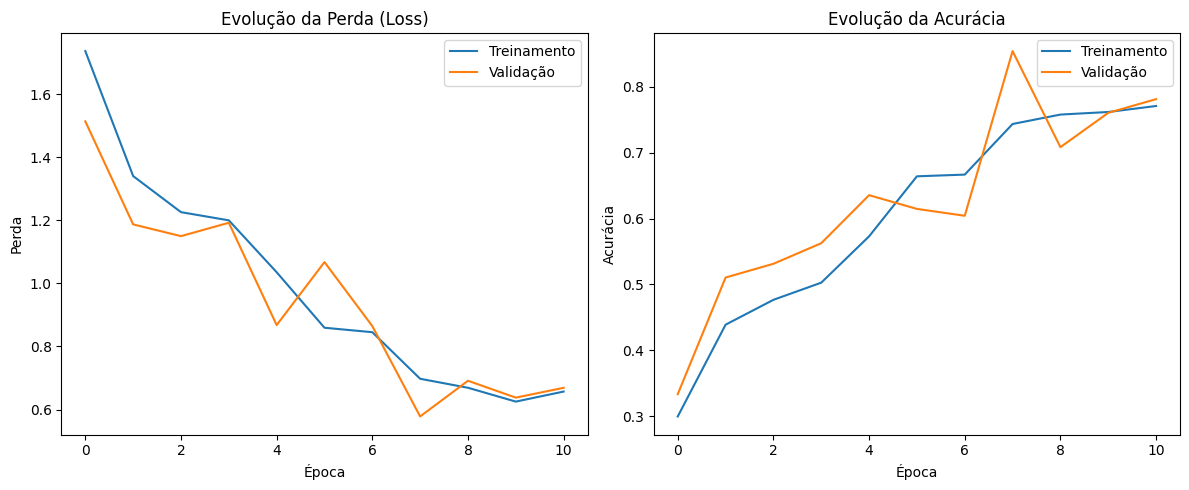

In [63]:
#Evolução das curvas de perda e acurácia

plt.figure(figsize=(12, 5))

# Curva de perda
plt.subplot(1, 2, 1)
plt.plot(history_cnn_no_reg.history['loss'], label='Treinamento')
plt.plot(history_cnn_no_reg.history['val_loss'], label='Validação')
plt.title('Evolução da Perda (Loss)')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()

# Curva de acurácia
plt.subplot(1, 2, 2)
plt.plot(history_cnn_no_reg.history['accuracy'], label='Treinamento')
plt.plot(history_cnn_no_reg.history['val_accuracy'], label='Validação')
plt.title('Evolução da Acurácia')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

plt.tight_layout()
plt.show()


Avaliar de novo.








Vemos que há indícios de overfitting, o que não surpreende dada a ausência de data augmentation nesse modelo. Podemos destacar que a acurácia de treinamento aumenta consistentemente, mas a de avaliação não acompanha o mesmo ritmo e oscila. De forma similar, a perda de validação começa a oscilar e até aumenta, mesmo com a perda de treino caindo.


### 3.3 Avaliação breve

<Figure size 1200x1000 with 0 Axes>

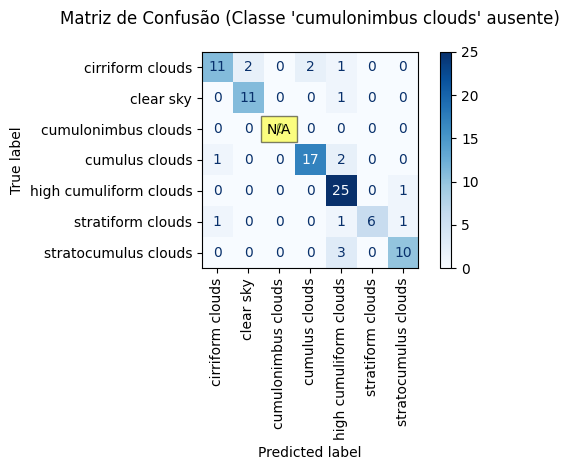


Classes presentes nos dados de teste:
['cirriform clouds', 'clear sky', 'cumulus clouds', 'high cumuliform clouds', 'stratiform clouds', 'stratocumulus clouds']

Relatório de Classificação:
                        precision    recall  f1-score   support

      cirriform clouds     0.8462    0.6875    0.7586        16
             clear sky     0.8462    0.9167    0.8800        12
        cumulus clouds     0.8947    0.8500    0.8718        20
high cumuliform clouds     0.7576    0.9615    0.8475        26
     stratiform clouds     1.0000    0.6667    0.8000         9
  stratocumulus clouds     0.8333    0.7692    0.8000        13

              accuracy                         0.8333        96
             macro avg     0.8630    0.8086    0.8263        96
          weighted avg     0.8450    0.8333    0.8309        96



In [67]:
# 1. Garantir que todas as classes estão representadas
unique_classes = np.unique(np.concatenate([y_true, y_pred]))
print("Classes presentes:", unique_classes)

# 2. Criar matriz de confusão com todas as classes
cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)))

# 3. Plotar com configurações robustas
plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_names  # Usar todos os nomes de classe originais
)

# 4. Configuração à prova de erros
plot = disp.plot(
    cmap='Blues',
    xticks_rotation=90,
    values_format='d',
    include_values=True
)

# Ajustes finais
plt.title("Matriz de Confusão - Modelo Base", pad=20, fontsize=14)
plt.xlabel('Predições', fontsize=12)
plt.ylabel('Valores Reais', fontsize=12)
plt.tight_layout()

# Verificar se há classes ausentes
if len(unique_classes) < len(class_names):
    missing = set(range(len(class_names))) - set(unique_classes)
    print(f"\nAviso: Classes ausentes nos dados de teste: {[class_names[i] for i in missing]}")

plt.show()

In [46]:
# Report básico
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

                        precision    recall  f1-score   support

      cirriform clouds       0.29      0.11      0.16        18
             clear sky       0.00      0.00      0.00         6
   cumulonimbus clouds       0.00      0.00      0.00         4
        cumulus clouds       0.31      0.41      0.35        22
high cumuliform clouds       0.30      0.25      0.27        24
     stratiform clouds       0.00      0.00      0.00        11
  stratocumulus clouds       0.12      0.18      0.15        11

              accuracy                           0.20        96
             macro avg       0.15      0.14      0.13        96
          weighted avg       0.21      0.20      0.20        96



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 4. CNN com regularização

### 4.1 Definindo o modelo

In [47]:
model_cnn = Sequential([
    layers.Input(shape=(128,128, 3)),

    #Data augmentation
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),

    layers.Rescaling(1./255),  # Normalização

    # Blocos Convolucionais
    layers.Conv2D(32, (3, 3), activation="relu", padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, (3, 3), activation="relu", padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, (3, 3), activation="relu", padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Flatten + camada densa
    layers.Flatten(),
    layers.Dense(64, activation="relu"),  # Processa o resultado do flatten
    layers.Dropout(0.3),  # Regularização
    layers.Dense(64, activation="relu"),
    layers.Dense(7, activation="softmax")  # 7 classes
])

### 4.2 Treinamento

In [48]:
model_cnn.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_cnn = model_cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)]
)

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 163ms/step - accuracy: 0.2066 - loss: 1.9282 - val_accuracy: 0.3542 - val_loss: 1.6265
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step - accuracy: 0.3242 - loss: 1.6427 - val_accuracy: 0.3750 - val_loss: 1.4974
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.4159 - loss: 1.4417 - val_accuracy: 0.3646 - val_loss: 1.4282
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 0.4212 - loss: 1.4452 - val_accuracy: 0.4688 - val_loss: 1.2840
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - accuracy: 0.4449 - loss: 1.3078 - val_accuracy: 0.4896 - val_loss: 1.1386
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step - accuracy: 0.4734 - loss: 1.2705 - val_accuracy: 0.4271 - val_loss: 1.2127
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step - accuracy: 0.4736 - loss: 1.2807 - val_accuracy: 0.4167 - val_loss: 1.2048
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step - accuracy: 0.4684 - loss: 1.2412 - val_accuracy: 0.

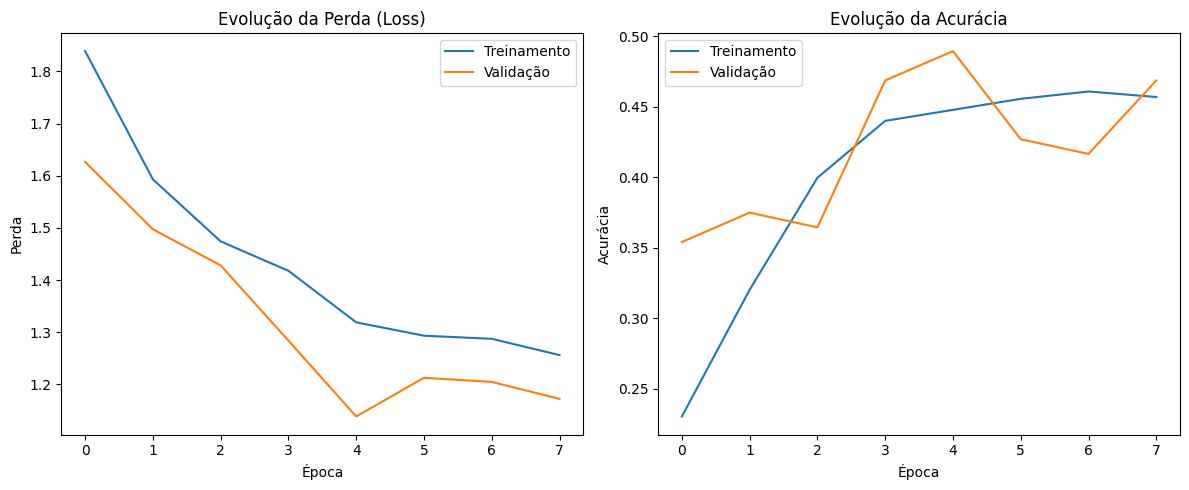

In [49]:
#Evolução das curvas de perda e acurácia

plt.figure(figsize=(12, 5))

# Curva de perda
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['loss'], label='Treinamento')
plt.plot(history_cnn.history['val_loss'], label='Validação')
plt.title('Evolução da Perda (Loss)')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()

# Curva de acurácia
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['accuracy'], label='Treinamento')
plt.plot(history_cnn.history['val_accuracy'], label='Validação')
plt.title('Evolução da Acurácia')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

plt.tight_layout()
plt.show()

### 4.3 Avaliação

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


<Figure size 1000x800 with 0 Axes>

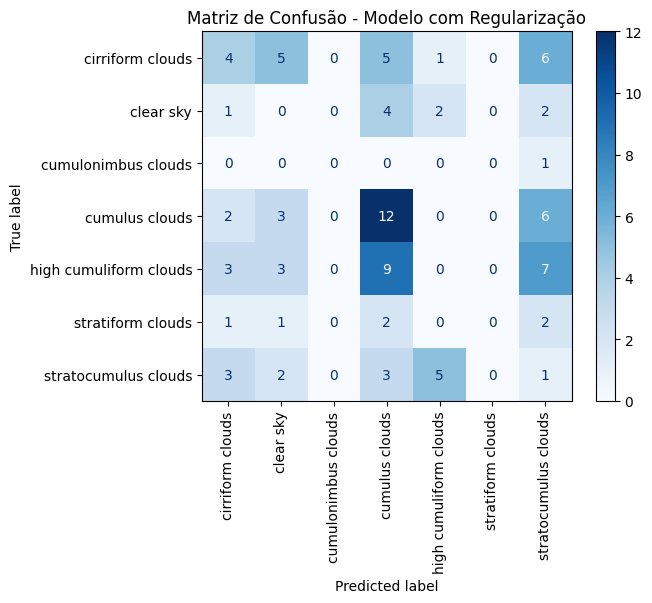

In [50]:
# Previsões (outputs da softmax)
y_pred_probs = model_cnn.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)  # Índices das classes preditas

#Rótulos verdadeiros
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for x, y in test_ds])

cm = confusion_matrix(y_true, y_pred)

# Visualizacao
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=90)
plt.title("Matriz de Confusão - Modelo com Regularização")
plt.show()


In [51]:
# Report básico
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

                        precision    recall  f1-score   support

      cirriform clouds       0.29      0.19      0.23        21
             clear sky       0.00      0.00      0.00         9
   cumulonimbus clouds       0.00      0.00      0.00         1
        cumulus clouds       0.34      0.52      0.41        23
high cumuliform clouds       0.00      0.00      0.00        22
     stratiform clouds       0.00      0.00      0.00         6
  stratocumulus clouds       0.04      0.07      0.05        14

              accuracy                           0.18        96
             macro avg       0.10      0.11      0.10        96
          weighted avg       0.15      0.18      0.16        96



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
